In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from workflows.sql_workflow import SQLWorkflow
from models.graph_state import GraphState
from models.llm import CHATLLM, BASELLM
from utils.data_utils import load_csv_to_sqlite
from configs.examples import EXAMPLES
from configs.schemas import SCHEMAS
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langgraph.errors import GraphRecursionError
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [26]:
csv_files = {
    "data/PET_PLACES.csv": "PET_PLACES",
    "data/CHILDREN_PLACES.csv": "CHILDREN_PLACES",
}

conn = load_csv_to_sqlite(csv_files)

c:\Users\jiyoo\OneDrive\PrompTart\TourGuideRAG
Loaded data/PET_PLACES.csv into table 'PET_PLACES'.
Loaded data/CHILDREN_PLACES.csv into table 'CHILDREN_PLACES'.


In [27]:
embeddings = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

In [28]:
# questions = [item["question"] for item in EXAMPLES]
# question_embeddings = [
#     (question, embeddings.embed_query(question)) for question in questions
# ]
# vectorstore_examples = FAISS.from_embeddings(
#     text_embeddings=question_embeddings, embedding=embeddings, metadatas=EXAMPLES
# )
# vectorstore_examples.save_local("faiss_example")

In [29]:
# Load FAISS index
vectorstore_examples = FAISS.load_local(
    "faiss_example", embeddings, allow_dangerous_deserialization=True
)

In [30]:
tour_rag = SQLWorkflow(CHATLLM, CHATLLM, vectorstore_examples)
app = tour_rag.setup_workflow()

c:\Users\jiyoo\OneDrive\PrompTart\TourGuideRAG
Loaded ./data/PET_PLACES.csv into table 'PET_PLACES'.


2025-02-16 15:56:01.350 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-16 15:56:01.352 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-02-16 15:56:01.365 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-16 15:56:01.365 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-16 15:56:01.366 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


WithPet


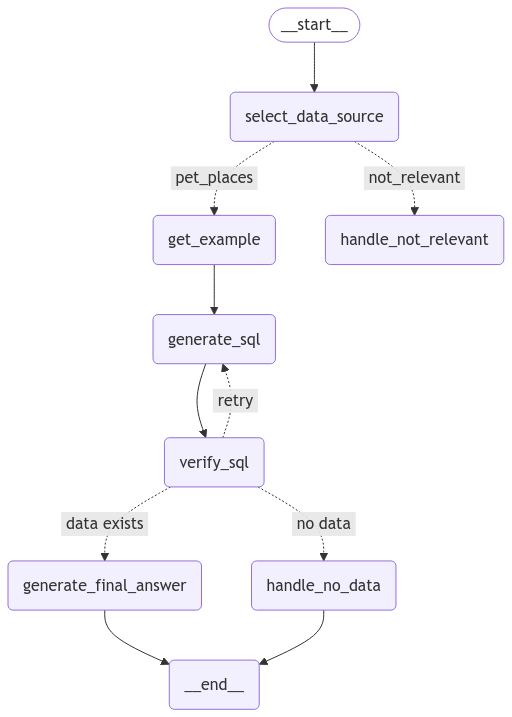

In [37]:
from IPython.display import Image, display

display(
    Image(app.get_graph(xray=True).draw_mermaid_png())
)  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다.

In [36]:
initial_state = GraphState(
    question="마이펫 영업시간",
)

try:
    result = app.invoke(initial_state, {"recursion_limit": 7})
    print("\n", result["answer"])
except GraphRecursionError:
    print("에러가 발생했습니다. 다시 시도해주세요.")

pet_places
<QUESTION> 서울 강남구에서 운영시간이 24시간인 동물병원을 알려주세요. </QUESTION>
<SQL> SELECT * FROM PET_PLACES WHERE LAND_LOT_ADDRESS LIKE '%서울특별시%강남구%' AND OPERATION_TIME LIKE '%00:00~24:00%' </SQL>

<QUESTION> 부산에 있는 추석 당일에 영업하는 약국 알려주세요. </QUESTION>
<SQL> SELECT * FROM PET_PLACES WHERE LAND_LOT_ADDRESS LIKE '%부산광역시%' AND CATEGORY_NM = '동물약국' AND HOLIDAY_INFORMATION NOT LIKE '%추석 당일%' </SQL>

<QUESTION> 서울에서 주말에 운영하는 반려동물 카페를 추천해주세요. </QUESTION>
<SQL> SELECT * FROM PET_PLACES WHERE LAND_LOT_ADDRESS LIKE '%서울특별시%' AND CATEGORY_NM = '카페' AND (OPERATION_TIME LIKE '%토%' AND OPERATION_TIME LIKE '%일요일%') </SQL>

 <SQL> SELECT * FROM PET_PLACES WHERE FACILITY_NM = '마이펫' </SQL>
Data Length:  3

 마이펫이라는 이름을 가진 시설에 대한 정보를 찾아보았습니다. 

1. 첫 번째로, 충청북도 제천시에 위치한 마이펫입니다. 주소는 충청북도 제천시 용두대로 59, 하소동 188-1이며, 전화번호는 0507-1334-5262입니다. 홈페이지 주소는 https://www.instagram.com/mypet_777이며, 연중무휴로 운영하고 있습니다. 주차장이 있으며, 모든 크기의 반려동물을 수용 가능합니다. 영업시간은 매일 09:00-21:00입니다.

2. 두 번째로, 부산광역시 금정구에 위치한 마이펫입니다. 주소는 부산광역시 금정구 온천장로125번길 50, 